# Searching for QPPs with GPs for the ISSI Team

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit, minimize

import celerite
from celerite import terms
import emcee

from glob import glob
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [2]:
files = glob('../flares/*.fits')

In [3]:
def aflare1(t, tpeak, fwhm, ampl):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723

    Use this function for fitting classical flares with most curve_fit
    tools.

    Note: this model assumes the flux before the flare is zero centered

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare

    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                (t > tpeak)],
                            [lambda x: (_fr[0]+                       # 0th order
                                        _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                        _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                        _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                        _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                            ) * np.abs(ampl) # amplitude

    return flare

In [10]:
# the liklihood fnction we'll need for the GP....

def neg_log_like(params, ynew, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(ynew)


0: Recovered Period = 30.5985751415 minutes


/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


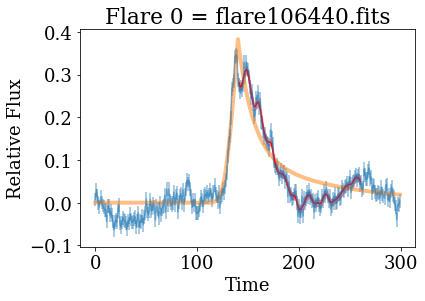

1: Recovered Period = 67.4071185481 minutes


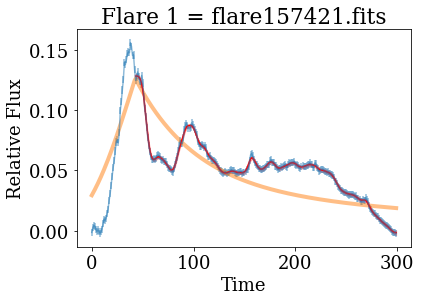

2: Recovered Period = 9.44718961931 minutes


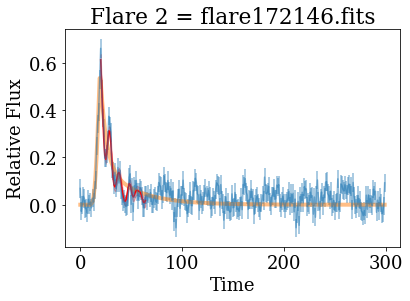

3: Recovered Period = 26.3058186086 minutes


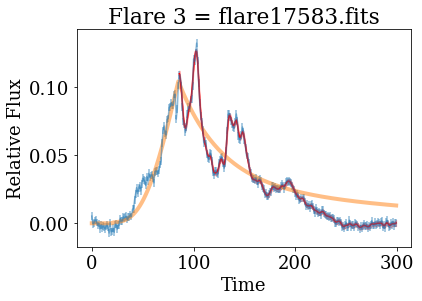

4: Suspect period =7493758.0678


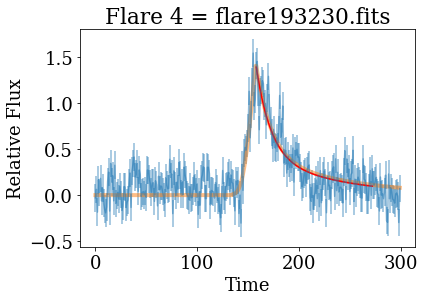

5: Recovered Period = 36.1308266613 minutes


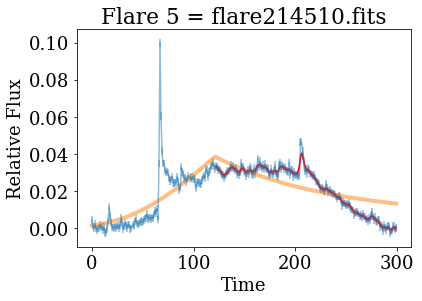

6: Recovered Period = 14.173483432 minutes


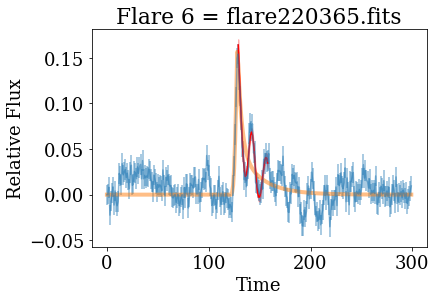

7: Recovered Period = 30.5996696068 minutes


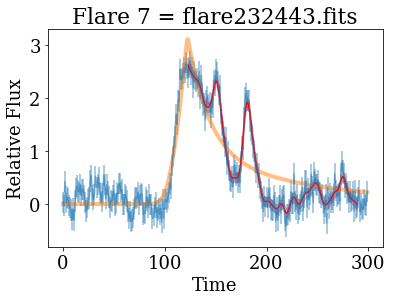

8: Recovered Period = 148.278240699 minutes


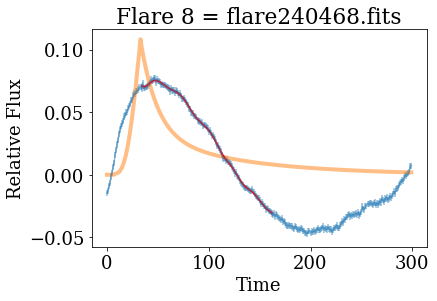

9: Suspect period =575.815668612


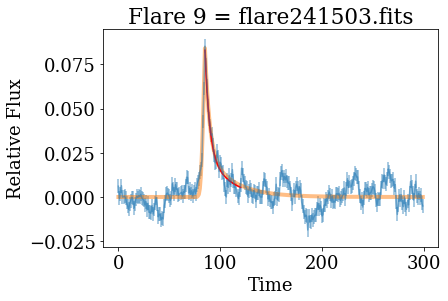

In [41]:
# do all: len(files)
for k in range(10): 

    hdu = fits.open(files[k])
    data = hdu[1].data
    hdu.close()

    time = data.field(0)
    
    medflux = np.nanmedian(data.field(1))
    
    # detrend any underlying shape... (this is frought with danger)
    # we shall assume:
    # A) the flare is not in the first or last 10 data points
    # B) a linear polynomial is enough (for now)
    
    c1 = np.nanmedian(data.field(1)[0:10])
    c2 = np.nanmedian(data.field(1)[-10:])
    t1 = np.nanmedian(data.field(0)[0:10])
    t2 = np.nanmedian(data.field(0)[-10:])

    slope = (c2 - c1) / (t2 - t1)
    inter = c2 - slope*t2
    
    flux = (data.field(1) - (slope * time + inter)) / medflux
    
    # find the typical (median) scatter in small chunks of the light curve 
    # (11 data points, arbitrarily chosen) to use as the error
    std = np.nanmedian(pd.rolling_std(flux, 11))
    err = np.ones(time.size) * std
    
    
    # get approximate properties of flare
    ampl = np.nanmax(flux)
    f05 = np.where((flux >= ampl*0.5))
    fwhm = np.nanmax(time[f05]) - np.nanmin(time[f05])
    p0 = [time[np.argmax(flux)], fwhm, ampl]
    
    popt, pcov = curve_fit(aflare1, time, flux, p0=p0)
    
    
    # the decay region:
    # do from PEAK to 5X the FWHM timescale (i.e. don't fit the out-of-flare region)
    decay = np.where((time >= popt[0]) & (time <= popt[0] + 5*popt[1]))
    
    #__ do the GP __
    tresid = time[decay]
    eresid = err[decay]
    fresid = flux[decay] - aflare1(time[decay], *popt)

    # DO WE TRUST ALL THESE KERNEL PARAMETERS????
    # Celerite SHO Kernel:
    Q = 1.0
    w0 = 3.0
    S0 = np.var(fresid) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))

    
    # draw the figure... put around the GP (annoyingly)
    plt.figure()
    plt.errorbar(time, flux, yerr=err, alpha=0.5)
    plt.plot(time, aflare1(time, *popt), alpha=0.5, lw=4)
    
    
    # wrap GP in Try/Except to catch some value error problem I don't understand
    try: 
        kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                                bounds=bounds)

        gp = celerite.GP(kernel, mean=np.mean(fresid))
        gp.compute(tresid, eresid)

        initial_params = gp.get_parameter_vector()
        bounds = gp.get_parameter_bounds()
        r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(fresid, gp))
        gp.set_parameter_vector(r.x)
        pred_mean, pred_var = gp.predict(fresid, tresid, return_var=True)
        pred_std = np.sqrt(pred_var)

    
        color = 'red'
        plt.plot(tresid, pred_mean + aflare1(tresid, *popt), color=color,label="GP") # GP fit
        plt.fill_between(tresid, pred_mean + pred_std + aflare1(tresid, *popt), 
                         pred_mean - pred_std + aflare1(tresid, *popt), 
                         color=color, alpha=0.3, edgecolor="none") # Standard deviation boundaries
        
        omega_0 = np.exp(gp.kernel.terms[0][2])
        period = (2*np.pi) / omega_0

        
        if (period < 200) & (period > 3):
            print(str(k) + ": Recovered Period = " + str(period) + " minutes")
        else:
            print(str(k) + ': Suspect period =' + str(period))
        
    except ValueError:
        print(str(k) + ': BAD/NO PERIOD (GP ERROR)')



    plt.xlabel('Time')
    plt.ylabel('Relative Flux')
    plt.title('Flare '+str(k)+' = ' + files[k][10:])
    plt.show()
    
    

    # To do inside loop (for each flare):
    # 1x) find flare peak
    # 2x) fit Davenport'14 flare model
    # 3x) fit GP on decay phase (residual)
    # 4) TRY: fit flare model + GP simultaneously w/ MCMC
    # 5x) make plot(s), produce table(s)



In [37]:
len(files)

101